In [12]:
import scipy.stats as st

import autograd.numpy as np
from autograd import grad
from autograd.scipy.stats import multivariate_normal

import matplotlib.pyplot as plt
%matplotlib inline

import tqdm

In [13]:

def hamiltonian_monte_carlo(n_samples, negative_log_prob, initial_position, path_len, step_size):
    """
        Run Hamiltonian Monte Carlo sampling.
    """
    # random step size
    if step_size is None:
        step_size = np.random.uniform(0.01,0.05) # DO TRIALS TO FIND BEST STEP SIZE
    # autograd
    dVdq = grad(negative_log_prob)

    # collect all samples in a list
    samples = [initial_position]

    # Keep a single object for momentum resampling
    momentum = st.norm(0, 1)

    # If initial_position is a 10d vector and n_samples is 100, we want
    # 100 x 10 momentum draws. We can do this in one call to momentum.rvs, and
    # iterate over rows
    size = (n_samples,) + initial_position.shape[:1]
    print(size)
    print(initial_position)
    count = 0 # to keep track of how many samples we've drawn
    for p0 in momentum.rvs(size=size):
        # print(p0)
        # Integrate over our path to get a new position and momentum
        q_new, p_new = leapfrog(
            samples[-1],
            p0,
            dVdq,
            path_len=path_len,
            step_size=step_size,
        )

        # Check Metropolis acceptance criterion
        start_log_p = negative_log_prob(samples[-1]) - np.sum(momentum.logpdf(p0))
        new_log_p = negative_log_prob(q_new) - np.sum(momentum.logpdf(p_new))
        if np.log(np.random.rand()) < start_log_p - new_log_p:
            samples.append(q_new)
            count += 1
        else:
            samples.append(np.copy(samples[-1]))

    return np.array(samples[1:]), count


def leapfrog(q, p, dVdq, path_len, step_size):
    """Leapfrog integrator for Hamiltonian Monte Carlo.

    Parameters
    ----------
    q : np.floatX
        Initial position
    p : np.floatX
        Initial momentum
    dVdq : callable
        Gradient of the velocity
    path_len : float
        How long to integrate for
    step_size : float
        How long each integration step should be

    Returns
    -------
    q, p : np.floatX, np.floatX
        New position and momentum
    """
    q, p = np.copy(q), np.copy(p)
    p = np.float64(p)
    q = np.float64(q)
    p = p - 0.5*step_size * dVdq(q)  # half step
    for _ in range(int(path_len / step_size) - 1):
        q += step_size * p  # whole step
        p -= step_size * dVdq(q)  # whole step
    q += step_size * p  # whole step
    p -= 0.5*step_size * dVdq(q)  # half step

    # momentum flip at end
    return q, -p


In [14]:
momentum = st.norm(0, 1)
momentum.rvs(size=2)

array([0.16258702, 0.18420274])

In [15]:
negative_log_prob = lambda x: -np.log( (2/3)*multivariate_normal.pdf(x, [0,0], [[1., 0.0], [0.0, 1.]]) + (1/3)*multivariate_normal.pdf(x, [2,2], [[0.3*0.3, 0.3*0.3*0.8], [0.3*0.3*0.8, 0.3*0.3]]))
n_samples = 10000
initial_position = np.array([0.,0.])
burn_in = 1000
samples, count = hamiltonian_monte_carlo(n_samples, negative_log_prob, initial_position, path_len=10, step_size=0.1)
samples = samples[burn_in:]
avg_acceptance_rate = count / n_samples
print("Average acceptance rate:", avg_acceptance_rate)
empirical_mean = samples.mean(axis=0)

(10000, 2)
[0. 0.]
Average acceptance rate: 0.9861


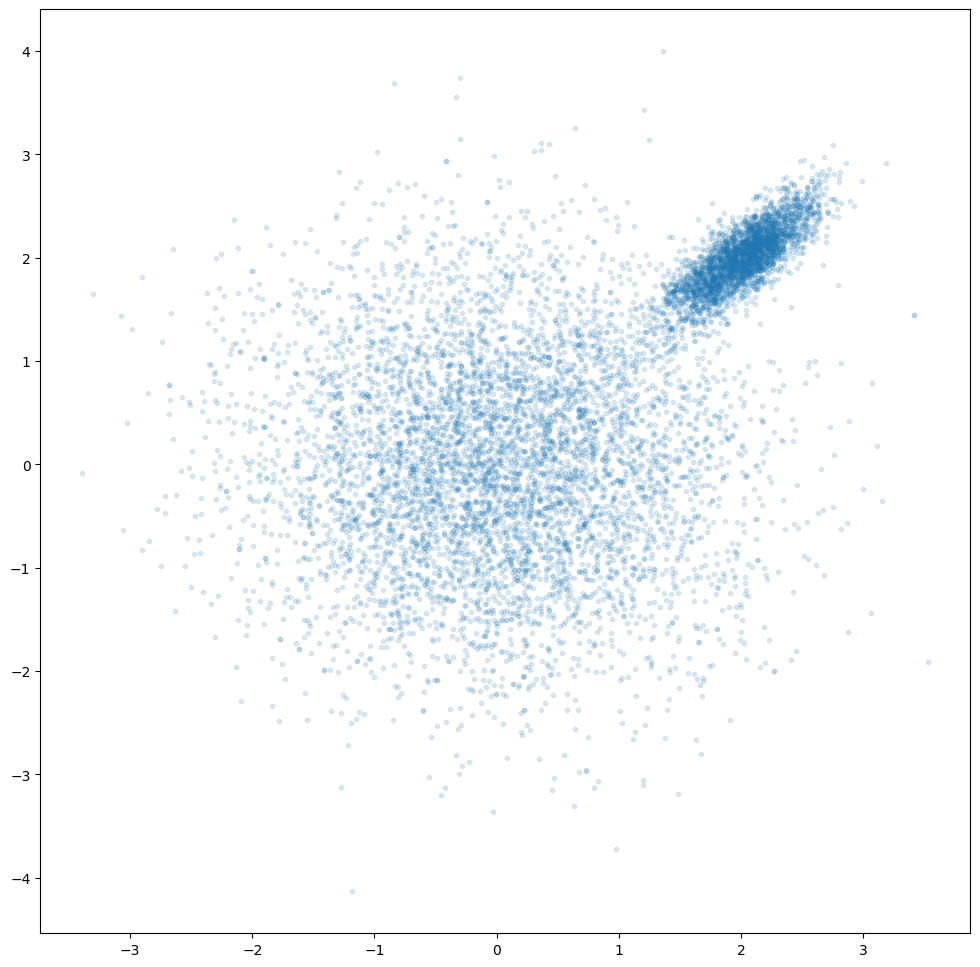

In [16]:
plt.figure(figsize=(12,12))
plt.plot(samples[:, 0], samples[:, 1], linestyle='', marker='o', markersize=3, alpha=0.15)

In [17]:
import seaborn as sns
sns.jointplot(samples[:, 0], samples[:, 1], kind='kde')

TypeError: jointplot() takes from 0 to 1 positional arguments but 2 positional arguments (and 1 keyword-only argument) were given